In [0]:
!git clone https://github.com/danagow/Urban/

Cloning into 'Urban'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [0]:
import os 
os.chdir('/content/Urban')
os.getcwd()

'/content/Urban'

In [0]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="4"
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import variable_scope
plt.rcParams['figure.figsize'] = 16, 8
%tensorflow_version 1.x

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
learning_rate = 0.001
total_epoch = 1000
batch_size = 64
dropout = 0.5
hidden_size = 200
index = 0

feed_train = {}
feed_val = {}
outputs = []
targets = []
DATAS = []
data_size = 6
datasets = {2: 'bareland', 3:'crop', 4:'forest', 5:'grass', 6:'rice', 7:'water'}

In [0]:
def dataplot(y_train, y_test, y_val):    
    f, axes = plt.subplots(1, 2, figsize=(18, 6))
    ax1, ax2 = axes
    sns.countplot(y_train, ax=ax1)
    ax1.set_xlabel('train')
    ax1.set_ylabel('number')
    ax1.set_ylim([0, 200])
    sns.countplot(y_test, ax=ax2)
    ax2.set_xlabel('test')
    ax2.set_ylabel('number')
    ax2.set_ylim([0, 200])
    plt.show()

def customized_rnn_seq2seq(encoder_inputs, decoder_inputs, cell, dtype=dtypes.float32, scope=None):
    with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
        enc_cell = copy.deepcopy(cell)
        encoder_outputs, enc_state = tf.contrib.rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
    return customized_rnn_decoder(encoder_outputs, decoder_inputs, enc_state, cell)
  
def customized_rnn_decoder(encoder_outputs, decoder_inputs, initial_state, cell, loop_function=None, scope=None):
    with variable_scope.variable_scope(scope or "rnn_decoder"):
        state = initial_state
        outputs = []
        prev = None
        for i, inp in enumerate(decoder_inputs):
            if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                    inp = loop_function(prev, i)
            if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
            output, state = cell(inp, state)
            outputs.append(output)
            if loop_function is not None:
                prev = output
    return encoder_outputs, outputs, state

def data_maker():
    data_train = np.loadtxt('train.txt', delimiter=',')
    data_test = np.loadtxt('test.txt', delimiter=',')
    dataholder = np.concatenate((data_train, data_test), axis=0)
    
    X_data = dataholder[:, 1:]
    y_data = dataholder[:, :1] -1
    y_data = y_data.reshape(y_data.shape[0]).tolist()
    # print(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=7, stratify=y_data)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8, stratify=y_train)

    # print(X_train.shape)
    # print(X_val.shape)
    # print(X_test.shape)
    # print(len(y_train))
    # print(len(y_val))
    # print(len(y_test))

    return X_train, y_train, X_val, y_val, X_test, y_test

def seq2seq_maker(index=1):
    X_train, y_train, X_val, y_val, X_test, y_test = data_maker()
    
    encoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]]) 
    decoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    target = tf.placeholder(tf.int64, [None])

    targets.append(target)
    
    with tf.variable_scope("rnn_" + str(index)):
        cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
        #output, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_input], [decoder_input], cell)
        en_outputs, de_outputs, state = customized_rnn_seq2seq([encoder_input], [decoder_input], cell)
        #print("encoder_outputs", encoder_outputs)
        #print("decoder_outputs", decoder_outputs)
        de_outputs = tf.reshape(de_outputs, [-1, hidden_size]) #3D -> 2D
        outputs.append(de_outputs)
    
    feed_train[encoder_input] = X_train
    feed_train[decoder_input] = X_train
    feed_train[target] = y_train
    
    feed_val[encoder_input] = X_val
    feed_val[decoder_input] = X_val
    feed_val[target] = y_val

In [0]:
seq2seq_maker()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
W = tf.Variable(tf.random_normal([hidden_size, 100]), name="W") 
b = tf.Variable(tf.random_normal([100]), name="b")
print("W", W)
print("b", b)
logits = [tf.matmul(output, W) + b for output in outputs]

with tf.variable_scope("cost"):
    loss = []
    for logit, target in zip(logits, targets):
        loss.append(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=target))
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    
#with tf.variable_scope("eval"):
#    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
#    correct_prediction = tf.equal(prediction, targets) #one-hot을 안쓰면 target에는 argmax할 필요없음
#    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W <tf.Variable 'W:0' shape=(200, 100) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(100,) dtype=float32_ref>


In [0]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("============================sess init")
    start_time = time.time()
    train_losses = []
    valid_losses = []

    for epoch in range(total_epoch):
        _, train_loss = sess.run([optimizer, cost], feed_dict = feed_train)
        _, val_loss = sess.run([optimizer, cost], feed_dict = feed_val)
        train_losses += [train_loss]
        valid_losses += [val_loss]
        if epoch % 100 == 0:  
            print("Epoch {}/{} took {:.3f}s".format(epoch + 1, total_epoch, time.time() - start_time))
            print("  Train      loss : %.6f" % (train_losses[epoch]))
            print("  Validation loss : %.6f" % (valid_losses[epoch]))
    print("It took", time.time() - start_time, "seconds to train for", total_epoch, "epochs.")        
    print("============================ training end")
    
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(valid_losses, '-r', label='Valid loss')
    plt.legend(loc=0)
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    #print('Accuracy:', sess.run(accuracy_op, feed_dict=feed_dict))
    #pred = sess.run(prediction, feed_dict=feed_dict)
    #for p, i in zip(pred, y_test.flatten()):
    #    print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))
        
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    save_path = saver.save(sess, "./weights.ckpt")
    print("model saved!")

In [0]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph("./weights.ckpt.meta")

In [0]:
learning_rate = 0.001
total_epoch = 1000
batch_size = 100 
dropout = 0.5
hidden_size = 200
index = 0

n_variable = 2

encoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="encoder_inputs") 
decoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="decoder_inputs")
targets = tf.placeholder(tf.int64, [None], name="targets")

X_train, y_train, X_val, y_val, X_test, y_test = data_maker()

with tf.variable_scope("seq2seq"):  
    cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
    outputs, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_inputs], [decoder_inputs], cell)
    outputs = tf.reshape(outputs, [-1, hidden_size]) #3D -> 2D
    print("outputs", outputs)  # output 모양이 항상 [? , hidden_size]으로 고정됨

    W = tf.get_default_graph().get_tensor_by_name("W:0")
    b = tf.get_default_graph().get_tensor_by_name("b:0")
    print("W", W)
    print("b", b)
    logits = tf.matmul(outputs, W) + b

with tf.variable_scope("cost_2"):
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

with tf.variable_scope("eval_2"):
    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
    correct_prediction = tf.equal(prediction, targets) #one-hot을 안쓰면 target에는 argmax할 필요없음
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

outputs Tensor("seq2seq/Reshape:0", shape=(?, 200), dtype=float32)
W Tensor("W:0", shape=(200, 100), dtype=float32_ref)
b Tensor("b:0", shape=(100,), dtype=float32_ref)


INFO:tensorflow:Restoring parameters from ./weights.ckpt
... check point loaded
[[-8.9056915e-01 -6.8794090e-01 -1.4464505e-01 ...  6.8473238e-01
  -6.4914525e-01 -3.8956097e-01]
 [ 3.0807054e+00 -1.9528091e+00  1.5147591e+00 ...  5.6752324e-01
  -6.1523080e-01  1.0491300e+00]
 [ 1.9457369e-01 -1.1639270e+00 -1.1549143e+00 ... -2.1084769e-01
   1.8903056e+00  2.6843724e-01]
 ...
 [ 8.9068212e-02  5.8476835e-01 -1.4645219e+00 ...  1.7654209e+00
   2.8968027e-01  1.6521661e+00]
 [-7.4706441e-01  4.7630543e-01  1.1937943e+00 ... -3.5146934e-01
   3.2763103e-01 -7.0557845e-01]
 [-3.9751451e-03 -8.8978946e-01  1.2592645e+00 ...  4.5020014e-01
  -6.9136485e-02  4.9864664e-04]]
[ 2.41374522e-02  7.06887305e-01 -6.33686259e-02  1.28505552e+00
  5.73394477e-01  4.81804848e-01  3.05523604e-01 -7.31236100e-01
 -1.55808425e+00  4.55682427e-01 -1.24185789e+00  8.84429872e-01
  6.05149977e-02  9.18680549e-01 -2.14804009e-01  1.46342754e+00
  3.01124960e-01 -7.01783001e-01 -2.65118074e+00  7.00695157

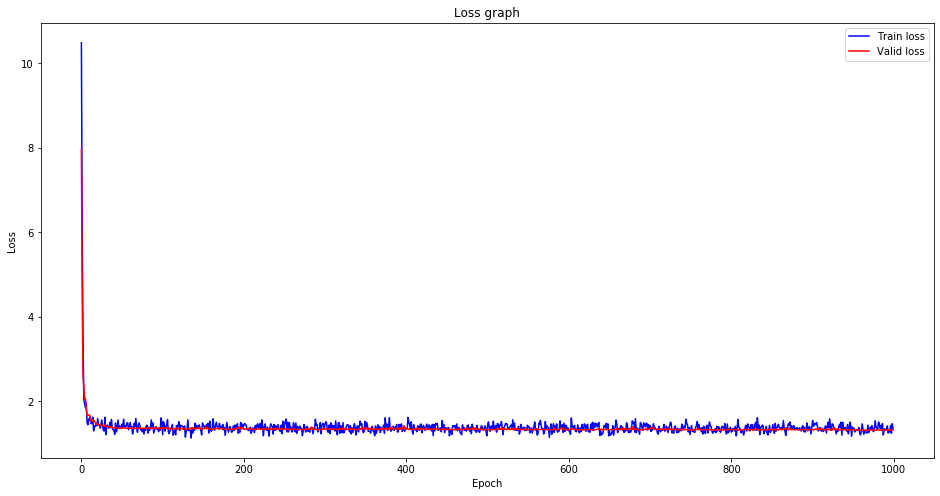

[False] Prediction: 3 True Y: 2
[False] Prediction: 5 True Y: 4
[False] Prediction: 3 True Y: 1
[False] Prediction: 3 True Y: 6
[True] Prediction: 5 True Y: 5
[False] Prediction: 3 True Y: 6
[True] Prediction: 5 True Y: 5
[False] Prediction: 3 True Y: 5
[True] Prediction: 5 True Y: 5
[True] Prediction: 5 True Y: 5
[False] Prediction: 5 True Y: 3
[False] Prediction: 3 True Y: 5
[False] Prediction: 3 True Y: 2
[False] Prediction: 3 True Y: 5
[True] Prediction: 6 True Y: 6
[True] Prediction: 6 True Y: 6
[False] Prediction: 3 True Y: 5
[True] Prediction: 6 True Y: 6
[False] Prediction: 5 True Y: 3
[False] Prediction: 5 True Y: 2
[True] Prediction: 3 True Y: 3
[False] Prediction: 3 True Y: 6
[False] Prediction: 5 True Y: 2
[False] Prediction: 5 True Y: 3
[False] Prediction: 5 True Y: 3
[True] Prediction: 3 True Y: 3
[True] Prediction: 5 True Y: 5
[False] Prediction: 5 True Y: 2
[False] Prediction: 3 True Y: 5
[True] Prediction: 5 True Y: 5
[False] Prediction: 5 True Y: 3
[False] Prediction:

In [0]:
train_losses = []
val_losses = []
new_saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "./weights.ckpt")
    print("... check point loaded")
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("=============================== training")
    start_time = time.time()

    for epoch in range(total_epoch):
        batch_mask = np.random.choice(len(X_train), batch_size)
        # print(batch_mask)
        X_batch = X_train[batch_mask]
        y_batch = np.array(y_train)[batch_mask]
        y_batch = y_batch.tolist()
        # Compute the losses
        _, tr_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_batch, decoder_inputs: X_batch, targets: y_batch})
        _, val_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_val, decoder_inputs: X_val, targets: y_val})
        # Log the losses
        train_losses += [tr_loss]
        val_losses += [val_loss]
  
        if epoch % 100 == 0:  
            print("Epoch {}/1000 took {:.3f}s".format(epoch + 1, time.time() - start_time))
            print("  Train loss : %.6f"%(train_losses[epoch]))
            print("  valid loss : %.6f"%(val_losses[epoch]))

    print("============================ training end")
    print('Accuracy:', sess.run(accuracy_op, feed_dict={encoder_inputs: X_test, decoder_inputs: X_test, targets: y_test}))
    
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(val_losses, '-r', label='Valid loss')
    plt.legend(loc=0)
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    pred = sess.run(prediction, feed_dict={encoder_inputs: X_test, decoder_inputs: X_test})
    for p, i in zip(pred, y_test):
        print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))